## INSURANCE CASE CANADA

A car insurance company has information about renewal rates for 20,000 customers. They want to know about the __key drivers__ that influence a customer's decision. This information will help them determine the changes,if any, this firm needs to make in order to achieve its targets.

First Let's import all required packages.

In [15]:
import pandas as pd
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score
from sklearn import metrics

 ## Data Inputing and Cleaning.
 
 
 Let's now load the dataset to see the information we are going to be working with.

In [16]:
df= pd.read_csv("Insurance case_Canada (2).csv")
# Some rows were removed from the original dataset which had #Value!
# written in some columns instead of value.

df.drop('Grouped Change in Price', axis=1, inplace=True)
# this column was not needed

lst = df['% Change in Price vs last Year'].tolist()
df.drop('% Change in Price vs last Year', axis=1, inplace=True)

# This column will be modified and added again in future.
new_lst = []
for item in lst:
    new_lst.append(item.strip("%"))
new_lst1 = [float(i)/100 for i in new_lst]
df.head()

,Marital Status,AGE,Gender,Car Value,Years of No Claims Bonus,Annual Mileage,Payment Method,Acquisition Channel,Years of Tenure with Current Provider,Price,Actual Change in Price vs last Year,Renewed?
0,M,45,F,500,4,6000,Monthly,Inbound,4,289.4,-11.94,0
1,M,40,M,3000,8,6000,Monthly,Inbound,4,170.4,45.62,1
2,S,25,F,4000,4,4000,Monthly,Inbound,4,466.1,-123.15,1
3,M,42,M,1800,9,10000,Annual,Inbound,4,245.1,2.34,1
4,M,59,M,5000,9,3000,Annual,Inbound,4,240.5,42.56,0


It seems there are a number of independent variables that are categorical in nature. For successful interpretation, these variables need to be given a numerical value. We shall use __Dummy coding__ to modify our data frame.

In [17]:
# DataFrame consisting of dummy variables of categorical variables
Dummy_Marital_sex = pd.get_dummies(df['Marital Status'])
Dummy_Gender = pd.get_dummies(df['Gender'])
Dummy_Acquisition_Channel = pd.get_dummies(df['Acquisition Channel'])
Dummy_Payment_Method = pd.get_dummies(df['Payment Method'])

# Creating a dataframe of only numeric values.
df1 = df[['Car Value','AGE','Years of No Claims Bonus', 'Annual Mileage',\
          'Years of Tenure with Current Provider','Price','Actual Change in Price vs last Year', 'Renewed?']]

#Creating a DataFrame out of modified % Change in Price vs last Year.
dat1 = pd.DataFrame({'% Change in Price vs last Year': new_lst1})

#merging all dataframes together.
df1=df1.join(dat1)
df1=df1.join(Dummy_Marital_sex)
df1=df1.join(Dummy_Gender, rsuffix = "_")
df1=df1.join(Dummy_Acquisition_Channel)
df1=df1.join(Dummy_Payment_Method)
df1.head()

,Car Value,AGE,Years of No Claims Bonus,Annual Mileage,Years of Tenure with Current Provider,Price,Actual Change in Price vs last Year,Renewed?,% Change in Price vs last Year,D,...,W,C,F,M_,Aggreg,Direct,Inbound,Outbound,Annual,Monthly
0,500,45,4,6000,4,289.4,-11.94,0,-0.0396,0,...,0,0,1,0,0,0,1,0,0,1
1,3000,40,8,6000,4,170.4,45.62,1,0.3700,0,...,0,0,0,1,0,0,1,0,0,1
2,4000,25,4,4000,4,466.1,-123.15,1,-0.2100,0,...,0,0,1,0,0,0,1,0,0,1
3,1800,42,9,10000,4,245.1,2.34,1,0.0100,0,...,0,0,0,1,0,0,1,0,1,0
4,5000,59,9,3000,4,240.5,42.56,0,0.2200,0,...,0,0,0,1,0,0,1,0,1,0


Here each categorical variable is divided into multiple columns. For a single case, dummy variable of value 1 would decide its nature. For example, a male will have value of __1__ in __"M_"__ and __0__ in __"F"__. 
Next we must deal with outliers of our non-categorical variables.

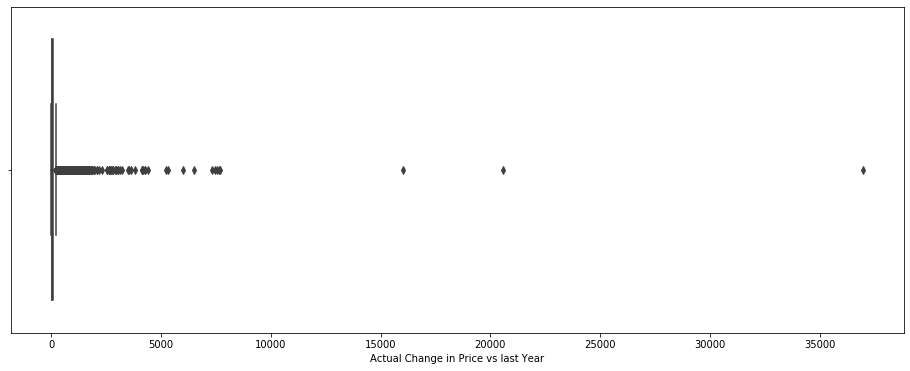

In [18]:
plt.figure(figsize=(16, 6))
sns.boxplot(x=abs(df1['Actual Change in Price vs last Year']))
#abs(df1['Actual Change in Price vs last Year']).describe()

a box-plot of absolute values of __"Actual Change in Price vs last Year"__ show extreme values. To make our analysis better, we shall remove all values where absolute change in price is greater than 1000.  

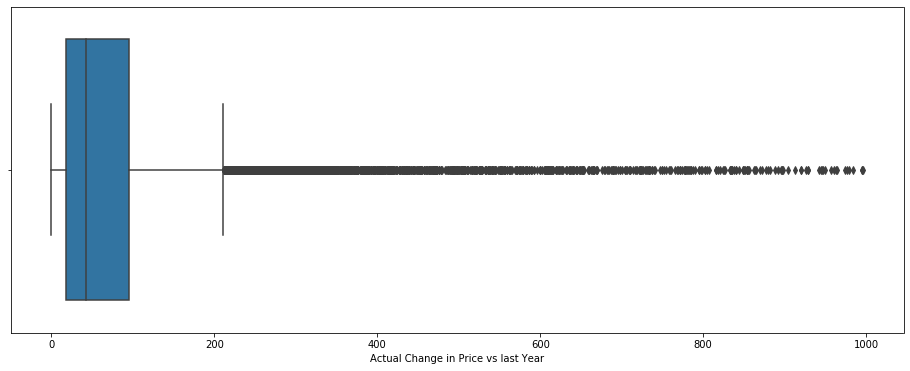

In [19]:
indexNames = df1[abs(df1['Actual Change in Price vs last Year']) - 1000 >= 0].index
#indexNames are index values of change in prices that are extreme. 
df1.drop(indexNames , inplace=True)
plt.figure(figsize=(16, 6))
sns.boxplot(x=abs(df1['Actual Change in Price vs last Year']))

In [20]:
len(indexNames)

158

## Logistic Regression

Let's prepare our data for regression:

In [21]:
Y = np.asarray(df1['Renewed?'])
X = np.asarray(df1[['AGE', 'Years of No Claims Bonus',
       'Years of Tenure with Current Provider', 'Price',
       'Actual Change in Price vs last Year',
       'D', 'M', 'S', 'V', 'W', 'C', 'F',
       'M_', 'Aggreg', 'Direct', 'Inbound', 'Outbound','Annual', 'Monthly']])
X[0]            

array([ 45.  ,   4.  ,   4.  , 289.4 , -11.94,   0.  ,   1.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ,   0.  ,   1.  ,
         0.  ,   0.  ,   1.  ])

Also, we normalize the dataset:

In [22]:
#X = X.reshape(-1, 1)
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0]

array([ 0.01725857, -0.61295142,  1.78158182, -0.5321192 , -0.21245569,
       -0.29197699,  0.92519258, -0.74302803, -0.06556351, -0.15226661,
       -0.03175083,  1.09932647, -1.09709498, -0.02458913, -0.49426536,
        0.49544808, -0.01229178, -0.61601981,  0.61601981])

## Train/Test dataset
Okay, we split our dataset into train and test set:

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  Y_train.shape)
print ('Test set:', X_test.shape,  Y_test.shape)

Train set: (15887, 19) (15887,)
Test set: (3972, 19) (3972,)


## Modeling

In [24]:
LR = LogisticRegression(C=0.01, solver='sag').fit(X_train,Y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

Now we can predict using our test set:

In [26]:
Yhat = LR.predict(X_test)
Yhat

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

## Evaluation
Lets try __jaccard index__ for accuracy evaluation. If the entire set of predicted labels for a sample strictly match with the true set of labels, then the subset accuracy is 1.0; otherwise it is 0.0.

In [27]:
jaccard_score(Y_test, Yhat)

0.6414027149321267

__A Decent model!__

Lets look at the values we have for our parameters
        

In [45]:
LR.coef_

array([[ 0.12109103, -0.02027361,  0.08695921, -0.32529685, -0.19440863,
        -0.03480768,  0.00549758,  0.01517186, -0.0134226 ,  0.00159445,
         0.02666001, -0.00548885,  0.00378929,  0.00944119, -0.00833798,
         0.00917712, -0.04643059, -0.22567012,  0.22567012]])

In [46]:
score = LR.score(X_test, Y_test)
print(score)

0.6807653575025177


In [47]:
LR.intercept_

array([0.51497551])

__What affects a customer's propensity to renew?__

By looking at the values of parameters, we can see the categorical variable __Payment Method__ ,numerical variables __Actual change in prices__ and __Age__ to be the most important factors. As expected, Actual change in prices is negatively related to our dependent variable with a value of __-0.19439748__, While age seems to have a positive relation with the value of __0.12108259__. Payment method indicates a customer is most likely to renew his insurance if he has a monthly payment system.

__How does change in price affect renewal rates?__


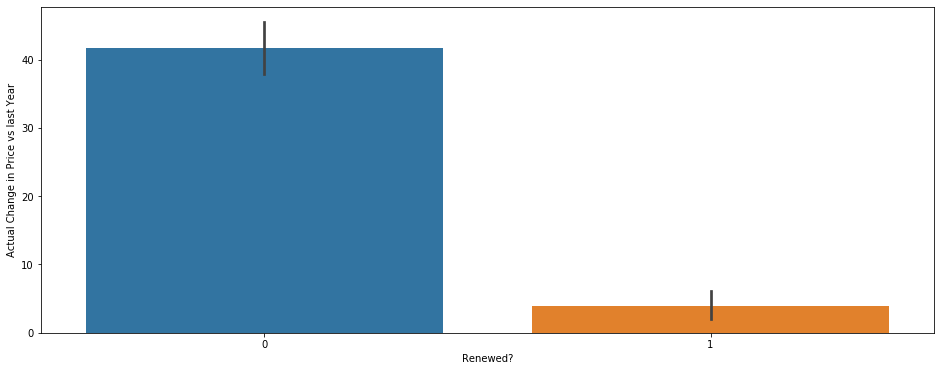

In [48]:
plt.figure(figsize=(16, 6))
sns.barplot(x=df1['Renewed?'],y=df1['Actual Change in Price vs last Year'])

Bar chart above shows relation between change in prices and renewal rates.It seems customers not renewing their policy is __highly associated__ with the change in price and those who have renewed their policy have enjoyed a relatively small change in price

__What are the key drivers of a customer's price elasticity?__

elasticity of price means degree of responsiveness in Quantity demanded(renewal rate) due to change in price. There are several factors that influence this figure. In North America, anyone who owns a car needs to purchase insurance, it is a __necessity__, indicating elasticity < 1, meaning degree of response is less than change in price.

Other key driver are the number of __substitutes__. If a lot of substitutes are available, an increase in price will prompt them to look for alternatives, indicating elasticity > 1.

One other could be the __proportion of total expenditure premium payments__ make. Usually, a young person will have a high premium and thus will be relatively inelastic compared to an elderly.

In [49]:
Total_obs=df1['Renewed?'].count()
renew= df1['Renewed?'].sum()
renew_rate = (renew/Total_obs)*100
print(renew_rate)
# proportion of customers that renewed.

62.344528928949096


## Conclusion

Advice for the company will depend on price elasticity of renewals. Since we do not have information regarding renewal rate of last year, it is hard to get that value.

__if elasticity > 1__, on average, __reducing the price__ of premiums will generate more than proportionate change in renewal rate, Total revenue will increase as revenue gained through higher renewal rate is greater than loss of revenue due to increase in price.

__if elasticity < 1__, on average, __increasing the price__ of premiums will generate less than proportionate change in renewal rate, Total revenue will increase as revenue gained through higher price is greater than loss of revenue due to lower renewal rate.

__if elasticity = 1__, on average, __reducing or increasing the price__ of premiums price will not affect total revenue by a significant amount as change in price is bringing same proportionate change in renewal rate.